# Convolutional Neural Network Image Classification Project

In [29]:
# Import our dependencies
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Generate a tf.data.Dataset

In [30]:
base_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

### List the folders to see their arrangement

In [31]:
os.listdir(base_dir)

['test', 'train', 'valid']

### Create train, test and validation datasets

In [32]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(200, 200),
batch_size=32)

Found 613 files belonging to 4 classes.


In [33]:
testing_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(200, 200),
batch_size=32)

Found 315 files belonging to 4 classes.


In [34]:
valid_set = tf.keras.preprocessing.image_dataset_from_directory(
valid_dir,
seed=101,
image_size=(200, 200),
batch_size=32)

Found 72 files belonging to 4 classes.


## Early Stopping

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
             EarlyStopping(patience=20)
]

## Data Augmentation

In [36]:
data_augmentation = tf.keras.Sequential(
  [tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(200,200,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),]
)

## Build CNN

In [37]:
model = Sequential([
    #data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='softmax')
])

### Compile Model

In [38]:
model.compile(optimizer='adam',
              #loss=keras.losses.BinaryCrossentropy(from_logits=True),
              loss=keras.losses.CategoricalCrossentropy(),
              #loss=keras.losses.mse,
              metrics=[keras.metrics.Accuracy()])

### Train the model

In [39]:
history = model.fit(training_set,validation_data=valid_set, epochs=600,callbacks=callbacks)

Epoch 1/600


c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - 3s 101ms/step - loss: -857.9899 - accuracy: 0.1876 - val_loss: -3457.7290 - val_accuracy: 0.2917
Epoch 2/600
20/20 [==============================] - 2s 93ms/step - loss: -39060.2109 - accuracy: 0.1876 - val_loss: -120903.7344 - val_accuracy: 0.2917
Epoch 3/600
20/20 [==============================] - 2s 94ms/step - loss: -716635.0000 - accuracy: 0.1876 - val_loss: -1478663.3750 - val_accuracy: 0.2917
Epoch 4/600
20/20 [==============================] - 2s 93ms/step - loss: -5582109.0000 - accuracy: 0.1876 - val_loss: -8334293.5000 - val_accuracy: 0.2917
Epoch 5/600
20/20 [==============================] - 2s 94ms/step - loss: -27459682.0000 - accuracy: 0.1876 - val_loss: -37476928.0000 - val_accuracy: 0.2917
Epoch 6/600
20/20 [==============================] - 2s 93ms/step - loss: -102968504.0000 - accuracy: 0.1876 - val_loss: -129180768.0000 - val_accuracy: 0.2917
Epoch 7/600
20/20 [==============================] - 2s 96ms/step - loss: -32094

KeyboardInterrupt: 

# Model attempt 2: use notebook from kaggle as inspiration


link: https://www.kaggle.com/code/prthmgoyl/ensemblemodel-ctscan

In [103]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [104]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [106]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    #class_mode= 'categorical'
    #class_mode='sparse'
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode='sparse',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode='sparse',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode='sparse',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [107]:
# Get Dataframes
base_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data'
train_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data/train'
test_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data/valid'
valid_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data/test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 613 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.


In [108]:
train_df

,filepaths,labels
0,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
2,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
3,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
4,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
...,...,...
608,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
609,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
610,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
611,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


## First pass at base CNN model

In [125]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Create convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [126]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_123 (Conv2D)         (None, 52, 52, 64)        36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 563

In [127]:
# Add dense layers to finish model 
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

In [128]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_123 (Conv2D)         (None, 52, 52, 64)        36928     
                                                                 
 flatten_10 (Flatten)        (None, 173056)          

In [129]:
train_gen.labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [130]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True
                  ),
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen, epochs=100, 
                    validation_data=(test_gen))

Epoch 1/100
16/16 [==============================] - 4s 222ms/step - loss: 91.4973 - accuracy: 0.3931 - val_loss: 1.0100 - val_accuracy: 0.5139
Epoch 2/100
16/16 [==============================] - 3s 221ms/step - loss: 0.9589 - accuracy: 0.6003 - val_loss: 0.8987 - val_accuracy: 0.5417
Epoch 3/100
16/16 [==============================] - 3s 209ms/step - loss: 0.4239 - accuracy: 0.8450 - val_loss: 0.9161 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 3s 203ms/step - loss: 0.2843 - accuracy: 0.9054 - val_loss: 1.1185 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 3s 208ms/step - loss: 0.2336 - accuracy: 0.9347 - val_loss: 1.1962 - val_accuracy: 0.5556
Epoch 6/100
16/16 [==============================] - 3s 206ms/step - loss: 0.1506 - accuracy: 0.9494 - val_loss: 1.0794 - val_accuracy: 0.6528
Epoch 7/100
16/16 [==============================] - 3s 206ms/step - loss: 0.1144 - accuracy: 0.9657 - val_loss: 1.2287 - val_accuracy: 0.569

## First pass at pretrained model

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, 
                                                  weights="imagenet", 
                                                  input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
              #loss='categorical_crossentropy', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100


c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - ETA: 0s - loss: 1.2662 - accuracy: 0.5514
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model.h5
16/16 [==============================] - 17s 795ms/step - loss: 1.2662 - accuracy: 0.5514 - val_loss: 1.2674 - val_accuracy: 0.6000
Epoch 2/100


c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7798
Epoch 2: val_accuracy improved from 0.60000 to 0.68254, saving model to best_model.h5
16/16 [==============================] - 9s 582ms/step - loss: 0.5639 - accuracy: 0.7798 - val_loss: 0.9758 - val_accuracy: 0.6825
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8548
Epoch 3: val_accuracy improved from 0.68254 to 0.69841, saving model to best_model.h5
16/16 [==============================] - 9s 604ms/step - loss: 0.3954 - accuracy: 0.8548 - val_loss: 0.9134 - val_accuracy: 0.6984
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9184
Epoch 4: val_accuracy improved from 0.69841 to 0.72698, saving model to best_model.h5
16/16 [==============================] - 9s 583ms/step - loss: 0.2461 - accuracy: 0.9184 - val_loss: 0.9133 - val_accuracy: 0.7270
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.2208 

In [131]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 1s 934ms/step - loss: 0.5282 - accuracy: 0.8889
Train Loss:  0.00037543600774370134
Train Accuracy:  1.0
--------------------
Validation Loss:  0.558479905128479
Validation Accuracy:  0.824999988079071
--------------------
Test Loss:  0.5281962752342224
Test Accuracy:  0.8888888955116272


In [132]:
from tensorflow.keras.applications import ResNet50

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, 
              #loss='categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.9556 - accuracy: 0.6852
Epoch 1: val_accuracy improved from -inf to 0.62222, saving model to best_model_resnet.h5
16/16 [==============================] - 16s 793ms/step - loss: 0.9556 - accuracy: 0.6852 - val_loss: 2.3746 - val_accuracy: 0.6222
Epoch 2/100


c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.9103
Epoch 2: val_accuracy improved from 0.62222 to 0.67619, saving model to best_model_resnet.h5
16/16 [==============================] - 11s 708ms/step - loss: 0.2509 - accuracy: 0.9103 - val_loss: 1.4321 - val_accuracy: 0.6762
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9560
Epoch 3: val_accuracy did not improve from 0.67619
16/16 [==============================] - 11s 717ms/step - loss: 0.1144 - accuracy: 0.9560 - val_loss: 1.1300 - val_accuracy: 0.6762
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9739
Epoch 4: val_accuracy improved from 0.67619 to 0.71111, saving model to best_model_resnet.h5
16/16 [==============================] - 11s 733ms/step - loss: 0.0811 - accuracy: 0.9739 - val_loss: 1.0310 - val_accuracy: 0.7111
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9837

In [133]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 976ms/step - loss: 0.6803 - accuracy: 0.8611
Train Loss:  0.0002217596338596195
Train Accuracy:  1.0
--------------------
Validation Loss:  0.7210680246353149
Validation Accuracy:  0.8500000238418579
--------------------
Test Loss:  0.6803328990936279
Test Accuracy:  0.8611111044883728


In [134]:
from tensorflow.keras.applications import InceptionV3
# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained InceptionV3 model
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, 
              #loss='categorical_crossentropy', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_inceptionv3.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 2.0653 - accuracy: 0.4894
Epoch 1: val_accuracy improved from -inf to 0.29524, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 8s 403ms/step - loss: 2.0653 - accuracy: 0.4894 - val_loss: 9.3756 - val_accuracy: 0.2952
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.1244 - accuracy: 0.6672
Epoch 2: val_accuracy did not improve from 0.29524
16/16 [==============================] - 5s 344ms/step - loss: 1.1244 - accuracy: 0.6672 - val_loss: 9.8300 - val_accuracy: 0.2032
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.9750 - accuracy: 0.6737
Epoch 3: val_accuracy improved from 0.29524 to 0.29841, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 6s 353ms/step - loss: 0.9750 - accuracy: 0.6737 - val_loss: 3.9341 - val_accuracy: 0.2984
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.8768 - 

In [135]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_inceptionv3.h5')


ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 536ms/step - loss: 1.4401 - accuracy: 0.6944
Train Loss:  0.03295724093914032
Train Accuracy:  1.0
--------------------
Validation Loss:  1.4334676265716553
Validation Accuracy:  0.6499999761581421
--------------------
Test Loss:  1.4401365518569946
Test Accuracy:  0.6944444179534912


In [136]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

input_shape=img_shape

model_inceptionv3 = load_model('best_model_inceptionv3.h5')
model = load_model('best_model.h5')
model_resnet = load_model('best_model_resnet.h5')

# Create input layer
input_layer = Input(shape=(input_shape))  # Replace input_shape with the appropriate shape for your models

# Get outputs from all three models
output_inceptionv3 = model_inceptionv3(input_layer)
output_model = model(input_layer)
output_resnet = model_resnet(input_layer)

# Average the predictions from all three models
average = Average()([output_inceptionv3, output_model, output_resnet])

# Create an ensemble model
ensemble_model = Model(inputs=input_layer, outputs=average)

# Save the ensemble model
ensemble_model.save('final_ensemble_model.h5')

In [137]:
model = load_model('final_ensemble_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

C:\Users\schre\AppData\Local\Temp\ipykernel_12384\2064879440.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0 0 1 1 3 1 3 1 1 3 1 1 1 1 1 1
 1 1 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 0 3 3 3 3 1 3 3 3 3]


In [138]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('final_ensemble_model.h5')

# Compile the model
# Replace 'optimizer' and 'loss' with your chosen optimizer and loss function
model.compile(optimizer='adam', 
              #loss='categorical_crossentropy', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Assuming you've defined test_gen and test_df
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

1/1 [==============================] - 5s 5s/step - loss: 0.9069 - accuracy: 0.8750
Test Loss: 0.9068764448165894
Test Accuracy: 0.875


In [139]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[20  0  0  3]
 [ 1 17  0  3]
 [ 0  0 13  0]
 [ 1  1  0 13]]
                         precision    recall  f1-score   support

         adenocarcinoma       0.91      0.87      0.89        23
   large-cell-carcinoma       0.94      0.81      0.87        21
                 normal       1.00      1.00      1.00        13
squamous-cell-carcinoma       0.68      0.87      0.76        15

               accuracy                           0.88        72
              macro avg       0.88      0.89      0.88        72
           weighted avg       0.89      0.88      0.88        72



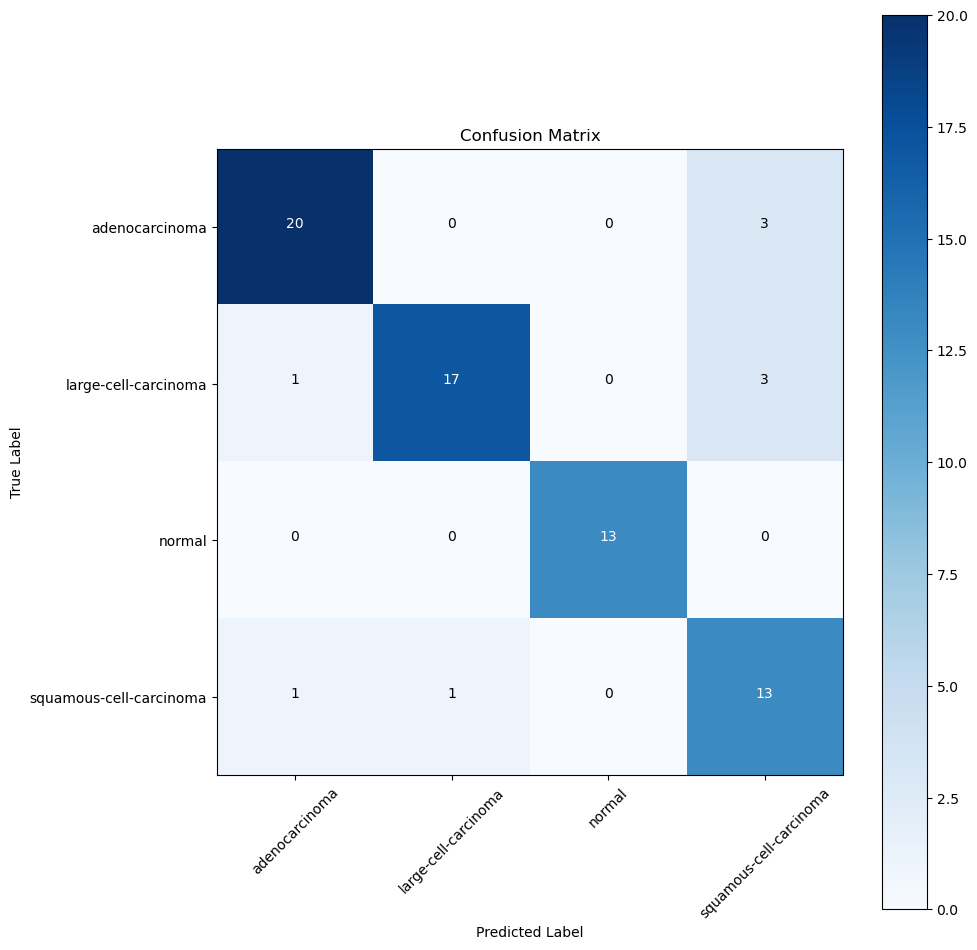

In [140]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))